[View in Colaboratory](https://colab.research.google.com/github/kundajelab/ssvmimp/blob/master/lsgkm.ipynb)

In [1]:
#install lsgkm
!rm -r lsgkm
! git clone https://github.com/kundajelab/lsgkm
% cd lsgkm/src
! make
! ./gkmtrain
%cd ../..

rm: cannot remove 'lsgkm': No such file or directory
Cloning into 'lsgkm'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 115 (delta 0), reused 1 (delta 0), pack-reused 111
Receiving objects: 100% (115/115), 247.05 KiB | 11.23 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/lsgkm/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
g++ -Wall -Wconversion -O3 -fPIC gkmtrain.c libsvm.o libsvm_gkm.o -o gkmtrain -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmpredict.c libsvm.o libsvm_gkm.o -o gkmpredict -lm -lpthread

Usage: gkmtrain [options] <posfile> <negfile> <outprefix>

 train gkm-SVM using libSVM

Arguments:
 posfile: positive sequence file (FASTA format)
 negfile: negative sequence file (FASTA format)
 outprefix: prefix of output file(s) <outprefix>.model.txt or
            <outprefix>.cvpred.txt

Options:
 -t <0 ~ 6>   set 

In [2]:
#get the raw data
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/master/deeplift/genomics/sequences.simdata.gz


Redirecting output to ‘wget-log’.


In [3]:
!zcat sequences.simdata | head

seqName	sequence	embeddings	task1	task2	task3
empty_1732	AGCTCTTTTGGCGGACCGAGTTCGTCGGACTTTCGCTAAATTGACCATTAACAGGAGGATACCCGGGTGTCTCGGGAAGGTCGTAATACGGTAATTACGGATGTGAGAGCGCACACATCCTTTGGATGATACATGATCTCGCCGTATATGGCCTAGGTCAAAAGGACAGTCTCGCTAATCGCAATAATGCAGCTAACCGA		0	0	0
gata_only_1527	TGCAGATAAGAACTTTGGGAATATGGTAGGAAAAACCCCTGAAGTGAGATCCAAAAAATATAGACTGGCGCGGTGGCAATGCCCTTGTTAATGCTGGGAATCAAAAAATCGAAACTCTCAGCAGATAAGATATGCAGACCTGCTCGTGGAGACAAAAAGTATTGTTACTGCGTAAACCATTAGTACGTTGCCGAGTACCG	pos-120_GATA_disc1-GCAGATAAGA,pos-1_GATA_disc1-GCAGATAAGA	0	1	0
gata_tal1_62	AGATTATAGGCCCTCCACCAGATAAGATATAGCGTTCGAGGGTCAGAAGGTAGTTCTGAAGATCTCTTCATTGTGAAAGGCCTCATATGATGAGCTTCTCCATTCTCAGCTGACAGGCAAAACAATTGATCAGCGCTTAGGCGCCAGATGTTTACTCCCGTTAAGTCAACTTAGCTGTGTTCGTCAAATCCGCAACGCGG	pos-17_GATA_disc1-CCAGATAAGA,pos-139_TAL1_known1-GGCGCCAGATGTTTAC	1	1	1
empty_1289	TTTGGGCGCGGAAGAAGTCGCTCGCCTTTCTGTACTTGAAAATGATTACATGTAAGGATGTAACTCAATCGCAACATTGTCATTGGGTTCCATCGCCCTAGCGGTAGTAGGTTTTACCTCCAACTTGACAACCCTTCGTAAATATAAAATAGTAGTAA

In [0]:
!zcat sequences.simdata.gz | perl -lane 'if ($F[3] eq "1") {print ">$F[0]\n$F[1]"}' > positives.fa
!zcat sequences.simdata.gz | perl -lane 'if ($F[3] eq "0") {print ">$F[0]\n$F[1]"}' > negatives.fa
!perl -ne 'if ($.%10 == 1 || $.%10 == 2) {print $_}' positives.fa > test_positives.fa
!perl -ne 'if ($.%10 != 1 && $.%10 != 2) {print $_}' positives.fa > train_positives.fa
!perl -ne 'if ($.%10 == 1 || $.%10 == 2) {print $_}' negatives.fa > test_negatives.fa
!perl -ne 'if ($.%10 != 1 && $.%10 != 2) {print $_}' negatives.fa > train_negatives.fa

In [5]:
!wc -l *.fa

  12000 negatives.fa
   4000 positives.fa
   2400 test_negatives.fa
    800 test_positives.fa
   9600 train_negatives.fa
   3200 train_positives.fa
  32000 total


In [6]:
import time

t=6
c=10
g=2
l=6
k=4
d=2

!lsgkm/src/gkmtrain -t $t -c $10 -g $2 -l $l -k $k -d $d -w 3 train_positives.fa train_negatives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3"


start = time.time()
!lsgkm/src/gkmpredict test_positives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3.model.txt" preds_positives.txt
end = time.time()
print("Time taken per seq:",(end-start)/400)
start = time.time()
!lsgkm/src/gkmpredict test_negatives.fa "params_t"$t"_l"$l"_k"$k"_d"$d"_g"$g"_c"$c"_w3.model.txt" preds_negatives.txt
end = time.time()
print("Time taken per seq:",(end-start)/1200)

import numpy as np
from sklearn.metrics import roc_auc_score
pos_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_positives.txt")]
neg_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_negatives.txt")]
print(roc_auc_score(y_true=np.array([1 for i in range(len(pos_preds))]+[0 for i in range(len(neg_preds))]),
                    y_score=np.array(pos_preds+neg_preds)))

INFO 2018-09-29 22:12:21: Number of threads is set to 1
INFO 2018-09-29 22:12:21: Arguments:
INFO 2018-09-29 22:12:21:   posfile = train_positives.fa
INFO 2018-09-29 22:12:21:   negfile = train_negatives.fa
INFO 2018-09-29 22:12:21:   outprefix = params_t6_l6_k4_d2_g2_c10_w3
INFO 2018-09-29 22:12:21: Parameters:
INFO 2018-09-29 22:12:21:   kernel-type = 6
INFO 2018-09-29 22:12:21:   L = 6
INFO 2018-09-29 22:12:21:   k = 4
INFO 2018-09-29 22:12:21:   d = 2
INFO 2018-09-29 22:12:21:   gamma = 2
INFO 2018-09-29 22:12:21:   C = 10
INFO 2018-09-29 22:12:21:   w = 3
INFO 2018-09-29 22:12:21:   eps = 0.001
INFO 2018-09-29 22:12:21:   shrinking = no
INFO 2018-09-29 22:12:21: reading 1600 sequences from train_positives.fa
INFO 2018-09-29 22:12:21: reading... 0
INFO 2018-09-29 22:12:21: reading... 1000
INFO 2018-09-29 22:12:21: reading... done
INFO 2018-09-29 22:12:21: reading 4800 sequences from train_negatives.fa
INFO 2018-09-29 22:12:21: reading... 0
INFO 2018-09-29 22:12:21: reading... 1000


In [7]:
!head -20 params_t0_l6_k4_d0_g2_c10_w3.model.txt

head: cannot open 'params_t0_l6_k4_d0_g2_c10_w3.model.txt' for reading: No such file or directory


In [0]:
import numpy as np
from collections import Counter
import itertools
from functools import reduce
import numpy as np


class GkmSvm(object):
  
  letter_to_num = {'A':0, 'C': 1, 'G': 2, 'T': 3}
  
  def __init__(self, kernel_type, l, k, d, gamma, rho,
               string_svs, signed_alphas):
    self.kernel_type = kernel_type
    assert k <= l
    assert d >= 0
    self.l = l
    self.k = k
    self.total_gkmers = (1 << (k << 1))
    self.d = d
    if (self.d!=(self.l-self.k)):
      self.k = self.l - self.d
      print("In the case of the gapped kmer counts kernels, it appears that "
            " d is redundant with l-k"
            " so I am setting k = l-d"
            " (e.g. when d=0, I found that the results are as though"
            "  l=k)")
    self.gamma = gamma
    self.rho = rho
    self.string_svs = string_svs
    self.signed_alphas = np.array(signed_alphas)
    self.build()
    
  def build(self):
    self.build_nongap_pos_sets()
    self.normalized_gkmer_count_svs = [self.get_normalized_gkmer_counts(x)
                                       for x in self.string_svs]
    self.gkmer_feature_space_size = len(self.nongap_pos_sets)*(4**self.k)
    
  def build_nongap_pos_sets(self):
    #get the placement of the non-gap positions
    redundant_nongap_pos_sets = list(itertools.combinations(range(self.l),
                                                            self.k))
    non_redundant_nongap_pos_sets = []
    string_reps_non_redundant_nongap_pos_sets = []
    for nongap_pos_set in redundant_nongap_pos_sets:
      string_rep_arr = [" " for i in range(self.l)]
      for a_pos in nongap_pos_set:
        string_rep_arr[a_pos] = "X"
      string_rep = "".join(string_rep_arr)
      if (string_rep in string_reps_non_redundant_nongap_pos_sets):
        assert False
        #print("Skipping",string_rep)
      #elif (string_rep[0]==" " or string_rep[-1]==" "):
      #  pass #gaps at the ends are evidently not used
      else:
        string_reps_non_redundant_nongap_pos_sets.append(string_rep)
        non_redundant_nongap_pos_sets.append(nongap_pos_set)
    self.nongap_pos_sets = non_redundant_nongap_pos_sets 
    nongap_pos_set_stringrep_to_idx = dict([(x,i) for (i,x)
      in enumerate(string_reps_non_redundant_nongap_pos_sets)])
    nongap_pos_set_rc_mapping = {}
    for string_rep in string_reps_non_redundant_nongap_pos_sets:
      orig_idx = nongap_pos_set_stringrep_to_idx[string_rep]
      rc_idx = nongap_pos_set_stringrep_to_idx[string_rep[::-1]]
      nongap_pos_set_rc_mapping[orig_idx] = rc_idx
    self.nongap_pos_set_rc_mapping = nongap_pos_set_rc_mapping
    self.idx_to_nongap_pos_set = dict(enumerate(self.nongap_pos_sets))
    
  def get_gkmer_vector(self, a_string):
    number_string = self.encode_as_numbers(a_string)
    k = self.k
    nongap_pos_sets = self.nongap_pos_sets
    to_count_up = []    
    for i in range(len(number_string)+1-self.l):
      for (nongap_pos_set_num,nongap_pos_set)\
        in enumerate(nongap_pos_sets):
        fwd_gkmer = 0
        rev_gkmer = 0
        for nongap_pos_enumidx, nongap_pos in enumerate(nongap_pos_set):
          #multiply the digit by the appropriate place value given by
          #nongap_pos_enumidx, add together
          fwd_gkmer |= number_string[i+nongap_pos] << (nongap_pos_enumidx << 1)
          rev_gkmer |= (3-number_string[i+nongap_pos]) << (
                        (self.k-1-nongap_pos_enumidx) << 1)
        #(1 << (k << 1)) is the same as 4**k
        fwd_gkmer += nongap_pos_set_num*(1 << (k << 1))
        rev_gkmer += self.nongap_pos_set_rc_mapping[nongap_pos_set_num]*(
                                                                  1 << (k << 1))
        to_count_up.append(fwd_gkmer)
        to_count_up.append(rev_gkmer)
    return to_count_up
  
  def compute_normalized_counts_from_gkmer_vector(self, gkmer_vector):
    counter_obj = Counter(gkmer_vector)
    norm = np.linalg.norm(list(counter_obj.values()))
    normalized_counts = dict([(x,y/norm) for x,y in counter_obj.items()])
    return normalized_counts
  
  def get_normalized_gkmer_counts(self, a_string):
    to_count_up = self.get_gkmer_vector(a_string=a_string)
    return self.compute_normalized_counts_from_gkmer_vector(
            gkmer_vector=to_count_up)
  
  def compute_dot_product(self, norm_gkmer_counts1, norm_gkmer_counts2):
    product = 0
    for a_key in norm_gkmer_counts1:
      if a_key in norm_gkmer_counts2:
        product += norm_gkmer_counts1[a_key]*norm_gkmer_counts2[a_key]
    assert np.abs(product) <= 1.0000001, (product, norm_gkmer_counts1,
                                                   norm_gkmer_counts2)
    return product
    
  def encode_as_numbers(self, a_string):
    return [self.letter_to_num[x] for x in a_string]
  
  def compute_importance_scores(self, the_seq, interpolation_steps_arr):
  
    gkmer_vector = self.get_gkmer_vector(the_seq)
    start = time.time()
    gradients = self.get_gradients(
        obs_norm_gkmer_counts=
          self.compute_normalized_counts_from_gkmer_vector(gkmer_vector),
        interpolation_steps_arr=interpolation_steps_arr)
    end1 = time.time()
    print("gradcomp time",(end1-start))
    scores = np.zeros((len(the_seq), 4))
    for idx,gkmers in enumerate(np.reshape(gkmer_vector,
                                                (-1,len(self.nongap_pos_sets),2))):
      for fwd_gkmer,rev_gkmer in gkmers:
        fwd_grad = gradients[fwd_gkmer]/self.k
        rev_grad = gradients[rev_gkmer]/self.k
        fwd_nonzero_positions = self.idx_to_nongap_pos_set[
                                 fwd_gkmer//self.total_gkmers]
        rev_nonzero_positions = self.idx_to_nongap_pos_set[
                                 rev_gkmer//self.total_gkmers]
        for fwd_pos in fwd_nonzero_positions:
          scores[idx+fwd_pos,self.letter_to_num[the_seq[idx+fwd_pos]]] += fwd_grad
        for rev_pos in rev_nonzero_positions:
          scores[idx+(self.l-1-rev_pos),self.letter_to_num[
                                       the_seq[idx+(self.l-1-rev_pos)]]] += rev_grad
  

class GaussianGkmSvm(GkmSvm):
  
  def __init__(self, *args, **kwargs):
    super(GaussianGkmSvm, self).__init__(*args, **kwargs)
    self.set_ref_norm_gkmer_counts(ref_norm_gkmer_counts={})
  
  def compute_prediction(self, a_string):
    normalized_gkmer_counts = self.get_normalized_gkmer_counts(a_string)
    svs_dot_products = []
    for normalized_gkmer_count_sv in self.normalized_gkmer_count_svs:
      svs_dot_products.append(self.compute_dot_product(
        norm_gkmer_counts1=normalized_gkmer_count_sv,
        norm_gkmer_counts2=normalized_gkmer_counts))
    svs_dot_products = np.array(svs_dot_products)
    return (np.sum(self.signed_alphas*np.exp(self.gamma*(svs_dot_products-1)))
            - self.rho)
  
  def set_ref_norm_gkmer_counts(self, ref_norm_gkmer_counts):
    self.ref_norm_gkmer_counts = ref_norm_gkmer_counts
    self.svs_dot_product_ref_norm_gkmer_counts = np.array([
        self.compute_dot_product(norm_gkmer_counts1=self.ref_norm_gkmer_counts,
                                 norm_gkmer_counts2=x)
        for x in self.normalized_gkmer_count_svs])
  
  def get_gradients(self, obs_norm_gkmer_counts, interpolation_steps_arr):
    assert (np.max(interpolation_steps_arr) <= 1
            and np.min(interpolation_steps_arr) >= 0), interpolation_steps_arr
    obs_minus_ref_norm_gkmer_counts = dict([
        (x,y-(self.ref_norm_gkmer_counts[x] if x in
              self.ref_norm_gkmer_counts else 0.0))
        for x,y in obs_norm_gkmer_counts.items()])
    svs_dot_product_obs_minus_ref_norm_gkmer_counts = np.array([
        self.compute_dot_product(
            norm_gkmer_counts1=obs_minus_ref_norm_gkmer_counts,
            norm_gkmer_counts2=x)
        for x in self.normalized_gkmer_count_svs])
    
    svs_by_interp_steps_common_terms_per_gkmer =(
      self.gamma*self.signed_alphas[:,None]*
        np.exp(self.gamma*(self.svs_dot_product_ref_norm_gkmer_counts[:,None]
          + (interpolation_steps_arr[None,:]*
             svs_dot_product_obs_minus_ref_norm_gkmer_counts[:,None])) - 1))
    
    gradients_on_obs_gkmers = {}
    for gkmer in obs_norm_gkmer_counts:
      this_gkmer_svs_norm_count = np.array([(x[gkmer] if gkmer in x else 0)
                                            for x in
                                            self.normalized_gkmer_count_svs])
      this_gkmer_obs_norm_count = obs_norm_gkmer_counts[gkmer]
      this_gkmer_ref_norm_count = (self.ref_norm_gkmer_counts[gkmer] if
                                   gkmer in self.ref_norm_gkmer_counts else 0)
      this_gkmer_obs_minus_ref_count = (this_gkmer_obs_norm_count -
                                        this_gkmer_ref_norm_count)
      this_gkmer_mean_grad = np.mean(np.sum((this_gkmer_svs_norm_count[:,None] -
                              (this_gkmer_ref_norm_count +
                               interpolation_steps_arr[None,:]*
                                this_gkmer_obs_minus_ref_count))*(
                              svs_by_interp_steps_common_terms_per_gkmer),
                              axis=0))
      gradients_on_obs_gkmers[gkmer] = this_gkmer_mean_grad
    return gradients_on_obs_gkmers    
  
  @classmethod
  def from_txt_file(cls, txt_file):
    lines = [x for x in open(txt_file)]
    
    field_name, kernel_type = lines[1].split()
    assert field_name=="kernel_type"
    assert kernel_type=="gkm_cnt_rbf"
    field_name, l = lines[2].split()
    assert field_name=="L"; l = int(l)
    field_name, k = lines[3].split()
    assert field_name=="k"; k = int(k)
    field_name, d = lines[4].split()
    assert field_name=="d"; d = int(d)
    field_name, gamma = lines[5].split()
    assert field_name=="gamma"; gamma = float(gamma)
    field_name, rho = lines[8].split()
    assert field_name=="rho"; rho = float(rho)
    
    string_svs = []
    signed_alphas = []
    assert lines[11].rstrip() == "SV"
    for a_line in lines[12:]:
      the_alpha, the_string = a_line.split()
      the_alpha = float(the_alpha)
      string_svs.append(the_string)
      signed_alphas.append(the_alpha)

    return cls(kernel_type=kernel_type,
        l=l, k=k, d=d, gamma=gamma, rho=rho, string_svs=string_svs,
        signed_alphas=np.array(signed_alphas))

  
class LinearGkmSvm(GkmSvm):

  def compute_prediction(self, a_string):
    normalized_gkmer_counts = self.get_normalized_gkmer_counts(a_string)
    svs_dot_products = []
    for normalized_gkmer_count_sv in self.normalized_gkmer_count_svs:
      svs_dot_products.append(self.compute_dot_product(
        norm_gkmer_counts1=normalized_gkmer_count_sv,
        norm_gkmer_counts2=normalized_gkmer_counts))
    svs_dot_products = np.array(svs_dot_products)
    return (np.sum(self.signed_alphas*svs_dot_products) - self.rho)

  @classmethod
  def from_txt_file(cls, txt_file):
    lines = [x for x in open(txt_file)]
    
    field_name, kernel_type = lines[1].split()
    assert field_name=="kernel_type"
    assert kernel_type=="gkm_cnt"
    field_name, l = lines[2].split()
    assert field_name=="L"; l = int(l)
    field_name, k = lines[3].split()
    assert field_name=="k"; k = int(k)
    field_name, d = lines[4].split()
    assert field_name=="d"; d = int(d)
    field_name, rho = lines[7].split()
    assert field_name=="rho"; rho = float(rho)
    
    string_svs = []
    signed_alphas = []
    assert lines[10].rstrip() == "SV"
    for a_line in lines[11:]:
      the_alpha, the_string = a_line.split()
      the_alpha = float(the_alpha)
      string_svs.append(the_string)
      signed_alphas.append(the_alpha)

    return cls(kernel_type=kernel_type,
        l=l, k=k, d=d, gamma=None, rho=rho, string_svs=string_svs,
        signed_alphas=np.array(signed_alphas))


In [0]:
model_file = "params_t6_l6_k4_d2_g2_c10_w3.model.txt"

!lsgkm/src/gkmpredict test_positives.fa $model_file preds_positives.txt
end = time.time()
print("Time taken per seq:",(end-start)/400)
start = time.time()
!lsgkm/src/gkmpredict test_negatives.fa $model_file preds_negatives.txt
end = time.time()
print("Time taken per seq:",(end-start)/1200)

import numpy as np
from sklearn.metrics import roc_auc_score
test_pos_seqs = [x.rstrip() for i,x in enumerate(open("test_positives.fa"))
                  if i%2==1]
test_neg_seqs = [x.rstrip() for i,x in enumerate(open("test_negatives.fa"))
                  if i%2==1]
pos_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_positives.txt")]
neg_preds = [float(x.rstrip().split("\t")[1]) for x in open("preds_negatives.txt")]
print(roc_auc_score(y_true=np.array([1 for i in range(len(pos_preds))]+[0 for i in range(len(neg_preds))]),
                    y_score=np.array(pos_preds+neg_preds)))
print(pos_preds[:10])
print(neg_preds[:10])

In [38]:
gkm_svm_model = GaussianGkmSvm.from_txt_file(model_file)

idx = 2
import time
start = time.time()
pred = gkm_svm_model.compute_prediction(test_pos_seqs[idx])
print(time.time()-start)
print(pred)
print(pos_preds[idx])

#scan a sequence to get all the kmers
#map kmer --> gapped (& mismatch kmers)

2.5512802600860596
0.5225323425693684
0.522532


In [69]:
!pip install deeplift

  Running setup.py bdist_wheel for deeplift ... - \ done
  Stored in directory: /root/.cache/pip/wheels/de/c4/b0/ec9deaa25dfaad60ad234f1d17b0339a8a9f5bfe4d7de42edd
Successfully built deeplift


In [67]:
import time

the_seq = test_pos_seqs[idx]
interpolation_steps_arr = 0.1*(np.arange(10)+0.5)
self = gkm_svm_model



gradcomp time 14.075441598892212
all time 14.103862285614014


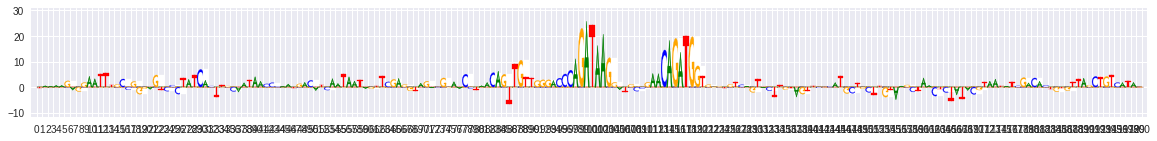

In [70]:
from deeplift.visualization import viz_sequence
viz_sequence.plot_weights(scores)

2.604424238204956
0.5225323425693684
0.522532


KeyError: ignored